# Trabalho de grupo
##### Elementos do grupo:
- Guilherme Sousa Silva Martins, A92847
- Maria Miguel de Oliveira Soares, A92826

##### Mestrado Integrado em Engenharia Física - 1º Ano - 2º Semestre;      Universidade do Minho        ;         2020
### - Unidade Curricular: Dados e Computação (DC);                         Professor: Jorge Sousa Pinto

##### Bibliografia: 'Automata and Computability: A Programmer's Perspective', por Ganesh Gopalakrishnan

ESPAÇO DEDICADO à Importação de funções do JOVE:

In [2]:
import sys
sys.path[0:0] = ['../','../3rdparty'] # Put these at the head of the search path

from jove.SystemImports       import *
from jove.DotBashers          import *
from jove.TransitionSelectors import *

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)



Os conjuntos de funções importados anteriormente pretencem ao JOVE e serão bastante úteis para a construção de autómatos.

# Autómatos de Pilha (PDA)

A categoria dos autómatos que nos iremos debruçar são os autómatos de pilha (PDA). Os autómatos de pilha, ou pushdown automata, generalizam a noção de autómatos não-determinísticos com a particularidade de lhes ser acrescentada uma estrutura de dados, uma **pilha de símbolos**. 

Uma pilha (stack) é essencialmente uma lista em que o acesso só é possível à cabeça. A operação de inserção chama-se *push*, e a de remoção chama-se *pop*.


Assim, um autómato de pilha é um tuplo $(Q, \Sigma, \Gamma, \delta, q_0,F)$ em que:

* $Q$ é o conjunto de estados;
* $\Sigma$ é o alfabeto de símbolos lidos pelo autómato;
* $\Gamma$ é o alfabeto dos símbolos inseridos na pilha;
* $\delta : Q \times \Sigma_\varepsilon \times \Gamma \to \mathcal{P}(Q\times \Gamma^*)$ é a função de transição 
* $q_0 \in Q$ é o estado inicial;
* $z_0$ é um campo especial e específico para guardar o elemento cardinal $#$, bastante útil futuramente para o  desenho de algoritmos de PDA;
* $F \subseteq Q$ é o conjunto de estados finais.

    ___NOTA___: em contraste com os autómatos estudados nos notebooks anteriores, o domínio da função de trasição $\delta$ deixa de conter duplos para ter triplos, sendo:
    * o 1º elemento do triplo um estado de $Q$;
    * o 2º elemento o símbolo da palavra que queremos ler;
    * e o último o símbolo que vai ser lido em cada transição efetuda no autómato e que se encontra no topo da pilha. 

   Em relação ao co-domínio da função referida, este passa a conter duplos, sendo:
    * o 1º elemento o estado (pertencente a $Q$) resultante da leitura do símbolo inicalmente no triplo;
    * e o 2º elemento os novos símbolos que vão ser adicionados na topo da pilha, em detrimento do que estava inicalmente no topo.

## Construção de Autómatos de Pilha (PDA)

À semelhança do que se sucedeu com os DFA e os NFA, o Jove também nos perimitirá uma representação de um PDA, onde também terá como estrutrura base os dicionários. 

De seguida, mostrámos um exemplo de um autómato de pilha:

In [3]:
PDA_bkts = { 
           'Q'     : {'IF', 'A'},
           'Sigma' : {'(',')'},
           'Gamma' : {'(',')','#'},
           'Delta' : { ('IF','(','#') : { ('A','(#') },   # push #; push (
                       ('A','(','(')  : { ('A','((') },   # push (; push (
                       ('A',')','(')  : { ('A','') },     # push Nothing
                       ('A','','#')   : { ('IF','#') }    # push #
                     },
           'q0'    : 'IF',
           'z0'    : '#',
           'F'     : {'IF'}
         }


Analisando cada campo é importante verificar que: 
* o campos Q, Sigma, Gamma e F são conjuntos;
* o campo Delta, é um outro dicionário, sendo esta a estrutura adequada para a representação de funções. As chaves deste dicionário são trios (estado, símbolo de Sigma, simbolo de Gamma ), e os valores são um par (estado, símbolos da stack)
* o campo q0 e z0 é um estado.


Para a visualização dos autómatos é utilizada a função `dotObj_pda`, como se ilustra, de seguida, para a representação do  autómato anteriormente descrito. 

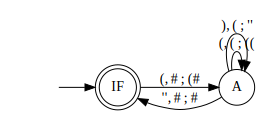

In [4]:
dotObj_pda(PDA_bkts)

### Coerência dos PDA

Podemos verificar a consistência de um PDA atráves da função `chk_consistent_pda` (pertencnete à biblioteca do JOVE).


Por estarmos a trabalhar com uma estrutura nativa do Python, os dicionários, será importante criar uma definição que testa a coerência dos PDA, a fim de estes estarem de acordo com a definição anteriormente descrita.

Assim, a `chk_consistent_pda_DC` terá de garantir os seguintes pontos:
* **Conjunto de estados**
    
    No que diz respeito ao conjunto de estados do autómato $Q$ precisámos de garantir que não se trata de um conjunto vazio.
    
    
* **Alfabeto Sigma**
    
    Relativamente ao alfabeto que contém os símbolos lidos pelo autómato, precisámos de garantir que este não é um conjunto vazio. Para além disso, o conjunto de símbolos tem de ser um sub-conjunto em relação ao alfabeto Gamma. 
    

* **Alfabeto Gamma**
    
    O alfabeto Gamma ao tratar-se do conjunto de símbolos que podem ser inseridos na pilha, para verificar a coerência do autómato, temos de garantir que não se trata de um conjunto vazio. 


* **Função de transição**
    
    É importante para perceber o funcionamento dos PDA perceber como se processa a função de transição:
    
    * $\delta : Q \times \Sigma_\varepsilon \times \Gamma \to \mathcal{P}(Q\times \Gamma^*)$ 
        
        Assim, temos vários pontos que temos de testar ao nível da coerência destes autómatos:
        1. O domínio da função de transição tem de resultar do produto cartesiano entre o conjunto de estados $Q$, o alfabeto Sigma e incluíndo a palavra vazia $\Sigma_\varepsilon $ e o alfabeto Gamma $\Gamma $, constítuindo assim um triplo. 
        2. Relativamente ao co-domínio desta função temos de garantir que esta resulte num par (estado, símbolo da stack). 
       Para tal criámos a função `termina_Q_Z_Kleen`que testará então este segundo ponto. Ou seja, por um lado, vai à segunda coordenada do par e verificar se existe algum símbolo lá presente que não pertença ao alfabeto Gamma, pois neste caso, terá de retornar logo False. Por outro lado, em relação à primeira coordenada vai verificar se existe algum caso em que não corresponda a um estado do autómato, onde nesse caso, irá retornar False.  
       

* **Estado Inicial** 
    
    Relativamente, ao estado inicial precisámos apenas de garantir que este pertence ao conjunto de estados $Q$.
    
    
* **Conjunto de estados finais**
    
    No que diz respeito, ao conjunto de estados finais precisámos de garantir que é um sub-conjunto do conjunto de estados iniciais.
    
    
* **Símbolo Inicial da Stack**

    Relativamente a z0, precisámos de garantir que pertence ao alfabeto Gamma e que não é a palavra vazia, dado que a definição de transição obriga a que seja sempre popped (retirado) um símbolo da pilha, e como tal não haverá transições quando a pilha está vazia. 
    
    
Assim, se se verificar as condições, anteriormente, descritas a função retornar _True_ e caso contrário _False_, indicando não se verificar a coerência do autómato.

De seguida, então apresentámos a exemplificação da função anteriormente descrita.

In [5]:
def termina_Q_Z_Kleen (D):
    
    Range = fn_range (D["Delta"])
    Q = D["Q"]
    for i in Range:
        #print(i)
        for n in i:
            #print(n)
            for e in list (n [1]):
                #print(e)
                    if e not in (D["Gamma"]):
                          return False
                        
        for (a,b) in i:
            #print (a)
            if a not in Q:
                return False
            
    return True  

In [6]:
print (termina_Q_Z_Kleen (PDA_bkts))

True


In [7]:
def chk_consistent_pda_DC (D):

    Q     = D["Q"]
    Sigma = D["Sigma"]
    Gamma = D["Gamma"]
    Delta = D["Delta"]
    Q0    = D["q0"]
    z0    = D["z0"]
    F     = D["F"]
    
    dom_Delta = set (fn_dom (Delta))
    Sigma_E = (Sigma | set ({ ""}))
    
    
    return ( Q != {} and 
             Sigma != {} and
             Gamma != {} and
             dom_Delta <= set (product (Q, Sigma_E, Gamma)) and
             Sigma < Gamma and
             z0 in Gamma and
             z0 not in Sigma and
             "" not in Gamma and
            termina_Q_Z_Kleen (D)== True and 
             Q0 in Q and 
             F <= Q)    

In [8]:
print (chk_consistent_pda_DC (PDA_bkts))

True


### NOTA sobre Totalização dos PDA

Ao trabalharmos com PDA's assumiremos que as representações não são necessariamente totais, e não definiremos uma função de totalização, uma vez que esse procedimento potencialmente geraria autómatos de tamanho muito superior ao original, tendo em conta que a função de transição recebe agora, além de um estado e um símbolo da palavra, também um símbolo da _stack_ , e a totalização teria de considerar todas as combinações de símbolos em ambas as estruturas. Por exemplo no autómato `PDA_bkts`, em vez de 4 pontos no domínio de $\delta$ teríamos 12.

Consequentemente, antes de calcular uma transição $\delta(q, x, Y))$ deveremos sempre testar se $(q,x,Y) \in \text{dom}(\delta)$, ou seja, se cada triplo $(q,x,Y)$ pertence ao domínio da função $\delta$.

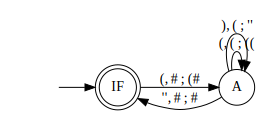

In [9]:
dotObj_pda(PDA_bkts)

### Aceitação de palavras

#### _Final State_ Acceptance

Uma função importante ao nível dos PDA será então uma que nos verifique se uma dada palavra é aceite ou não pelo autómato. A estratégia para a definição da função `accepts_df_inv` baseia-se numa travessia em profundidade.

Assim, para a definição da função `accepts_inv`, que recebe um autómato e uma palavra utilizámos a ajuda da função `accepts_df_inv` que irá então recebendo um autómato, um estado, a stack e uma palavra aplicando a travessia em profunidade inidcar se a palavra é aceite ou não.

Para a definição de `accepts_df_inv` temos vários casos:
* 1. No caso da palavra ser vazia e o estado em que nos encontrámos for um estado final do autómato, tratando-se do estado de aceitação ser por *final state* se a palavra foi então toda lida, siginifica que a palavra é aceite pelo autómato.

* 2. No caso, de a stack estar vazia, automaticamente nos faz concluir que a palavra não será aceite.

* 3. No caso então de a palavra não ser vazia e existir uma chave nas chaves da funçaõ de transição que é (q,w[0],S[0]), significa que existirá um valor para essa chave. Assim, para cada valor associado a essa chave vamos então aplicar a recursividade chamando, a função `accepts_df_inv` mas agora para (P, qn, toPush+S[1:], w[1:]), onde P representa o mesmo autómato, qn representa o estado do valor da chave, toPush o símbolo da stack do valor da chave, S[1:] a cauda da Stack e w[1:] a palavra recebida exceto o primeiro símbolo. No caso de se verificar a aceitação retornará True.

* 4. Pode ainda dar-se o caso de exsitirem transições mediante a leitura do palavra vazia, ainda assim, aplicaremos o mesmo raciocínio do ponto 3. Ou seja, procurando, o valor da chave (q,'',S[0]), iremos testar chamando a função `accepts_df_inv`se (P, qn, toPush+S[1:], w), com a pequena diferença de aplicarmos a função à palavra e não somente à cauda da mesma.



Qualquer outro caso, implicará a devoluçao de _False_, inidicando que não é aceite.

Assim, verificámos que esta função devolve apenas um valor _Booleano_, mas imprime, __por ordem inversa__, todas as configurações intermédias (estado, palavra, pilha) do autómato até à aceitação da palavra, caso seja aceite.

In [10]:
#adaptação da função fornecida pelo professor
def accepts_df_inv (P, q, S, w) :

    if w == "" and q in P["F"]:
        print(q + "\t" + w + "\t\t" + S)
        return True
    
    if S == "" : 
        return False
    
    if w != '' and (q,w[0],S[0]) in P['Delta'].keys():
        for (qn,toPush) in P['Delta'][(q,w[0],S[0])]  :
            #print (qn, toPush)
            if accepts_df_inv(P, qn, toPush+S[1:], w[1:]) :
                print(q + "\t" + w + "\t\t" + S)
                return True
            
    if (q,'',S[0]) in P['Delta'].keys():
        for (qn,toPush)  in P['Delta'][(q,'',S[0])] :
            #print (qn, toPush)
            if accepts_df_inv(P, qn, toPush+S[1:], w) :
                print(q + "\t" + w + "\t\t" + S)
                return True

    return False
            
    

def accepts_inv (P, w) : 
    return accepts_df_inv(P, P['q0'], P['z0'], w) 

Reparemos para o exemplo na aceitação (ou não) da palavra `(()())` pelo autómato `PDA_bkts`:

In [11]:
accepts_inv(PDA_bkts,  "(()())")

IF			#
A			#
A	)		(#
A	))		((#
A	())		(#
A	)())		((#
A	()())		(#
IF	(()())		#


True

Pela sua análise, concluímos que a palavra é aceite pelo autómato.

#### Exemplo

Apresentámos, então, de seguida um outro autómato. 
O autómato seguinte reconhece a linguagem $\{ a^i b^i \mid i \geq 0 \}$:

In [12]:
Pab1 = { 'Sigma' : {'a','b'},
         'Q'     : {'S0', 'S1', 'S2','S3'},
         'Gamma' : {'a','b','1',"#"},
         'Delta' : {('S0','a','#'): {('S1','1#')},
                    ('S1','a','1'): {('S1','11')},
                    ('S1','b','1'): {('S2','')},
                    ('S2','b','1'): {('S2','')},
                    ('S2','','#') : {('S3','')},
                   },
         'q0'    : 'S0',
         'z0'    : '#',
         'F'     : { 'S3' } 
       }
chk_consistent_pda(Pab1)

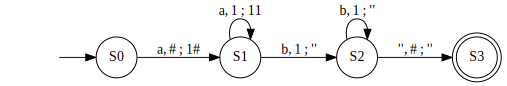

In [13]:
dotObj_pda(Pab1)

De seguida, podemos então visualizar a aplicação da função `accepts`.

In [14]:
accepts_inv (Pab1, "aabb")

S3			
S2			#
S2	b		1#
S1	bb		11#
S1	abb		1#
S0	aabb		#


True

### (exercício propostos pelo professor)

A fim de se tornar mais percetível a aplicação da função `accepts_inv` será útil criar-se uma definição onde imprima as configurações intermédias(estado, palavra, pilha) pela **ordem direta**, ao invés da ordem inversa como já o fizemos. 

Para isso imprimiremos as configurações intermédias após os ciclos e antes da entrada no if que chama, novamente, a função, de forma a que as configurações sejam impressas pela **ordem direta**. 

In [15]:
def accepts_df_dir (P, q, S, w) :

    if w == "" and q in P["F"]:
        print(q + "\t" + w + "\t\t" + S)
        return True
    
    if S == "" : 
        return False
    
    if w != '' and (q,w[0],S[0]) in P['Delta'].keys():
        for (qn,toPush) in P['Delta'][(q,w[0],S[0])]  :
            print(q + "\t" + w + "\t\t" + S)
            if accepts_df_dir(P, qn, toPush+S[1:], w[1:]) :
                
                return True
            
    if (q,'',S[0]) in P['Delta'].keys():
        for (qn,toPush)  in P['Delta'][(q,'',S[0])] :
            print(q + "\t" + w + "\t\t" + S)
            if accepts_df_dir(P, qn, toPush+S[1:], w) :
                
                return True

    return False
            
    

def accepts_dir (P, w) : 
    return accepts_df_dir(P, P['q0'], P['z0'], w) 



Assim, agora apresentámos a aplicação desta função aos autómatos anteriores (`Pab1` e `PDA_bkts`) podendo observar as configurações intermédias pela ordem direta, mantendo-se o output da função como sendo True ou False. 

In [16]:
accepts_dir (Pab1, "aabb")

S0	aabb		#
S1	abb		1#
S1	bb		11#
S2	b		1#
S2			#
S3			


True

In [17]:
accepts_dir (PDA_bkts,  "(()())")

IF	(()())		#
A	()())		(#
A	)())		((#
A	())		(#
A	))		((#
A	)		(#
A			#
IF			#


True

#### Empty Stack Acceptance

Umas das características dos autómatos de pilha passa por existir um outro critério de aceitação para além do critério por final state. Este critério de aceitação é o de pilha vazia (*empty stack*).

Assim, apresentaremos a definição de aceitação de uma palavra para um dado autómato por empty stack. Tendo por base o racíocinio utilizado para a definição de aceitação por final state torna-se muito fácil alterar o critério de aceitação para "pilha vazia". Para tal considerando os 4 casos apresentados em `accepts_df` basta então alterar o caso 1, ou seja, no caso de a palavra ser vazia e a stack se encontrar vazia a palavra será imediatamente declarada como aceite, contrariamente ao que acontecia na definição por final state em que a palavra é declarada aceite se já for a palavra vazia e se encontrar num estado final do autómato.

Assim a linha de raciocínio apresentada para os outros 3 casos mantém-se intacta comparativamente à definição por final state(`accepts_df`).

In [18]:
#definição fornecida pelo professor
def accepts_df_ES (P, q, S, w) :

    if w == "" and S == "":
        print(q + "\t" + w + "\t\t" + S)
        return True
    
    if S == "" : 
        return False
    
    if w != '' and (q,w[0],S[0]) in P['Delta'].keys():
        for (qn,toPush) in P['Delta'][(q,w[0],S[0])]  :
            if accepts_df_ES(P, qn, toPush+S[1:], w[1:]) :
                print(q + "\t" + w + "\t\t" + S)
                return True
            
    if (q,'',S[0]) in P['Delta'].keys():
        for (qn,toPush)  in P['Delta'][(q,'',S[0])] :
            if accepts_df_ES(P, qn, toPush+S[1:], w) :
                print(q + "\t" + w + "\t\t" + S)
                return True
            
    return False
                        

def accepts_ES (P, w) : 
    return accepts_df_ES(P, P['q0'], P['z0'], w) 


Apresentamos agora um outro autómato assim como a sua visualização.

In [19]:
Pab2 = {'Sigma' : {'a','b'},
        'Q'     : {'S0', 'S1', 'S2', 'S3'},
        'Gamma' : {'a','b','1','#'},
        'Delta' : {('S0','a','#'): {('S1','1#')},
                   ('S1','a','1'): {('S1','11')},
                   ('S1','b','1'): {('S2','')},
                   ('S2','b','1'): {('S2','')},
                   ('S2','','#') : {('S3','')},
                  },
        'q0'    : 'S0',
        'z0'    : '#',
        'F'     : set({  }) }
chk_consistent_pda(Pab2)

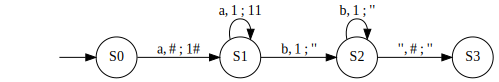

In [20]:
dotObj_pda(Pab2)

Podemos agora testar as nossas funções de aceitação de palavras quer por final state quer por empty stack, realtivamente a este recente autómato criado.

In [21]:
accepts_inv (Pab2, "aabb")

False

In [22]:
accepts_ES(Pab2, "aaabbb")

S3			
S2			#
S2	b		1#
S2	bb		11#
S1	bbb		111#
S1	abbb		11#
S1	aabbb		1#
S0	aaabbb		#


True

## PDA com um só estado

Tendo implementado a aceitação por _empty stack_, podemos agora definir autómatos (de um só estado) para o reconhecimento de linguagens livres de contexto. Por exemplo para a linguagem de parêntesis teremos o seguinte autómato, que nos ajudará a perceber que a simples função de aceitação, quando usada com um destes autómatos, está longe de constituir um _parser_ para a linguagem:

| $q$   | $x$           | $Y$ | Nome     | $q'$  | $S'$            |
| ------- | --------------- | ----- | -------- | ------- | ----------------- |
| $q_1$ | $\varepsilon$ | $S$ | expand-1 | $q_1$ | [ ( , $S$, ) ]  |
| $q_1$ | $\varepsilon$ | $S$ | expand-2 | $q_1$ | [ $S$ , $S$ ] |
| $q_1$ | $\varepsilon$ | $S$ | expand-3 | $q_1$ | [  ]              |
| $q_1$ | (               | (     | match-(  | $q_1$ | [  ]              |
| $q_1$ | )               | )     | match-)  | $q_1$ | [  ]              |



In [23]:
Ptopdown = {'Sigma' : {'(',')'},
            'Q'     : {'q1'},
            'Gamma' : {'(',')','S'},
            'Delta' : {('q1','','S')   :   {('q1','(S)'), ('q1','SS'), ('q1','')},
                       ('q1','(','(')  :   {('q1','')},
                       ('q1',')', ')') :   {('q1','')}
                      },
            'q0'    : 'q1',
            'z0'    : 'S',
            'F'     : set({  }) }
chk_consistent_pda(Ptopdown)

In [22]:
accepts_ES(Ptopdown,  "(()())")

RecursionError: maximum recursion depth exceeded in comparison

É fácil perceber a razão pela qual a função de aceitação não termina. Basta reparar na seguinte execução do autómato:

(( )( ))  --     S

(( )( ))  --    (S)

( )( ))   --    S)

( )( ))   --    (S))

)( ))     --    S))

)( ))     --    SS))

)( ))     --    S))

)( ))     --    SS))

... 


Note-se que neste ponto não existe qualquer escolha possível de transição que permita saír do ciclo...



## PDAs Generalizados (exercícios propostos pelo professor)

Os autómatos PDA podem ser generalizados permitindo-se a leitura, em cada transição, de uma _sequência de símbolos_ da pilha, em vez de exactamente um símbolo. 

Tal como referido na aula teórica, isso permitirá definir PDAs para reconhecimento _bottom-up_, como por exemplo o seguinte autómato para a linguagem de parêntesis, que não passa o critério de validade da função `chk_consistent_pda`. 

| $q$   | $x$           | $Y$             | Nome     | $q'$  | $S'$    |
| ------- | --------------- | ----------------- | -------- | ------- | --------- |
| $q_1$ | $\varepsilon$ | [ ), $S$, ( ]   | reduce-1 | $q_1$ | [ $S$ ] |
| $q_1$ | $\varepsilon$ | [ $S$ , $S$ ] | reduce-2 | $q_1$ | [ $S$ ] |
| $q_1$ | $\varepsilon$ | [  ]              | reduce-3 | $q_1$ | [ $S$ ] |
| $q_1$ | (               | [ ]               | shift-(  | $q_1$ | [ ( ]     |
| $q_1$ | )               | [ ]               | shift-)  | $q_1$ | [ ) ]     |





In [24]:
Pbottomup = {'Sigma' : {'(',')'},
             'Q'     : {'q1'},
             'Gamma' : {'(',')','S'},
             'Delta' : {('q1', '' , ')S(')   :    {('q1','(S)')},
                        ('q1', '' , 'SS')    :    {('q1','(S)')},
                        ('q1', '' , '')      :    {('q1','(S)')},
                        ('q1', '(', '')      :    {('q1','(')},
                        ('q1', ')', '')      :    {('q1',')')}
                      },
             'q0'    : 'q1',
             'z0'    : 'S',
             'F'     : set({  }) }
chk_consistent_pda(Pbottomup)

AssertionError: Delta has illegal stack symbol.

Como verificámos a coerência destes autómatos generalizados não é verificada, pelo que torna-se importante criarmos uma função que nos verifique a coerência destes PDA generalizados.

Para tal temos que garantir vários pontos:

* **Conjunto de estados**
    
    No que diz respeito ao conjunto de estados do autómato $Q$ precisámos de garantir que não se trata de um conjunto vazio.
    
    
* **Alfabeto Sigma**
    
    Relativamente ao alfabeto que contém os símbolos lidos pelo autómato, precisámos de garantir que este não é um conjunto vazio. Para além disso, o conjunto de símbolos tem de ser um sub-conjunto em relação ao alfabeto Gamma. 
    

* **Alfabeto Gamma**
    
    O alfabeto Gamma ao tratar-se do conjunto de símbolos que podem ser inseridos na pilha, para verificar a coerência do autómato, temos de garantir que não se trata de um conjunto vazio. 


* **Função de transição**
    
    É importante para perceber o funcionamento dos PDA perceber como se processa a função de transição. 
        
    Assim, temos vários pontos que temos de testar ao nível da coerência destes autómatos:
    
 1. O domínio da função de transição diferencia-se em relação aos PDA, o facto de agora permitir a leitura de mais do que um símbolo do alfabeto Gamma, ao invés de um só símbolo, assim para verificarmos este domínio usámos a função `verificar_dom`. Nesta função vai verificar para cada trio (a,b,c) pertencente ao domínio da função de transição, se:
 
 
   * existe algum **a** que não pertença ao conjunto de estados do autómato;
   * existe algum **b** que não pertença ao alfabeto *Sigma* mais a palavra vazia;
   * para a string associada a c, se existe algum símbolo que não pertença ao alfabeto Gamma;
            
     Caso, se verifique algo que foge então a estas 3 condições a função retornará logo False, retornando True, quando se verificam as 3 condições. 
        
        
 2. Relativamente ao co-domínio desta função temos de garantir que esta resulte num par (estado, símbolo da stack). 
       Para tal criámos a função `termina_Q_Z_Kleen`que testará então este segundo ponto. Ou seja, por um lado, vai à segunda coordenada do par e verificar se existe algum símbolo lá presente que não pertença ao alfabeto Gamma, pois neste caso, terá de retornar logo False. Por outro lado, em relação à primeira coordenada vai verificar se existe algum caso em que não corresponda a um estado do autómato, onde nesse caso, irá retornar False.  
       

* **Estado Inicial** 
    
    Relativamente, ao estado inicial precisámos apenas de garantir que este pertence ao conjunto de estados $Q$.
    
    
* **Conjunto de estados finais**
    
    No que diz respeito, ao conjunto de estados finais precisámos de garantir que é um sub-conjunto do conjunto de estados iniciais.
    
    
* **Símbolo Inicial da Stack**

    Relativamente a z0, precisámos de garantir que pertence ao alfabeto Gamma e que não é a palavra vazia, dado que a definição de transição obriga a que seja sempre popped (retirado) um símbolo da pilha, e como tal não haverá transições quando a pilha está vazia. 
    
    
Assim, se se verificar as condições, anteriormente, descritas a função retornar True e caso contrário False, indicando não se verificar a coerência do autómato.

De seguida, então apresentámos a exemplificação da função anteriormente descrita.


In [25]:
def verificar_dom (D):
    
    Sigma_E = (D ["Sigma"] | set ({ ""}))
   
    for (a,b,c) in (fn_dom (D ["Delta"])):
        if a not in D ["Q"]:
            return False
        if b not in Sigma_E:
            return False
        for i in c:
            if i not in (D ["Gamma"]):
                return False 
    
    return True

In [26]:
def termina_Q_Z_Kleen (D):
    
    Range = fn_range (D["Delta"])
    Q = D["Q"]
    for i in Range:
        #print(i)
        for n in i:
            #print(n)
            for e in list (n [1]):
                #print(e)
                    if e not in (D["Gamma"]):
                          return False
                        
        for (a,b) in i:
            #print (a)
            if a not in Q:
                return False
            
    return True  

In [27]:
def chk_consistent_gpda_DC (D):

    Q     = D["Q"]
    Sigma = D["Sigma"]
    Gamma = D["Gamma"]
    Delta = D["Delta"]
    Q0    = D["q0"]
    z0    = D["z0"]
    F     = D["F"]
    
    dom_Delta = set (fn_dom (Delta))
    Sigma_E = (Sigma | set ({ ""}))
    
    #if (z0 != ""):
     #   z0 in Gamma
      #  Sigma < Gamma
    #else:
     #   assert(Sigma <= Gamma),"PDA's Sigma not contained in Gamma."
    
    return ( Q != {} and 
             Sigma != {} and
             Gamma != {} and
             Sigma < Gamma and
             z0 in Gamma and
             z0 not in Sigma and
             "" not in Gamma and
            termina_Q_Z_Kleen (D)== True and 
             verificar_dom (D) == True and          
             Q0 in Q and 
             F <= Q)    

Vamos verificar a coerência do autómato PDA `Pbottomup`.

In [29]:
chk_consistent_gpda_DC(Pbottomup)

True

Assim, podmeos concluir que `Pbottomup` não é coerente.

### accepts_gES (NOTA dos criadores do trabalho de grupo)

A função `accepts_gES` é uma função de aceitação (_empty stack_) para autómatos generalizados. Para esat função, consideramos que a pilha é inicializada vazia, e uma palavra é aceite quando depois de inteiramente lida, a pilha contém apenas o símbolo especial 'z0'.

No entanto, em computação, é muito difícil tornar os métodos para a construção de autómatos PDA por *Top-Down* e *Bottom-Up* em processos determinísticos e eficientes. Por esta razão, não apresentamos uma definição (feita por nós) para `accepts_gES`.
